# Importing Libraries

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, cross_validate
from sklearn import model_selection
from sklearn.model_selection import TimeSeriesSplit
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor
from warnings import filterwarnings
filterwarnings('ignore')
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
import matplotlib.pylab as plt
import matplotlib.dates as mdates

## Examining the Dataset

In [29]:
df_ = pd.read_csv('/content/Energy_consumption_dataset.csv')
df = df_.copy()
df.head()

,Month,Hour,DayOfWeek,Holiday,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,EnergyConsumption
0,1,0,Saturday,No,25.139433,43.431581,1565.693999,5,On,Off,2.774699,75.364373
1,1,1,Saturday,No,27.731651,54.225919,1411.064918,1,On,On,21.831384,83.401855
2,1,2,Saturday,No,28.704277,58.907658,1755.715009,2,Off,Off,6.764672,78.270888
3,1,3,Saturday,No,20.080469,50.371637,1452.316318,1,Off,On,8.623447,56.519850
4,1,4,Saturday,No,23.097359,51.401421,1094.130359,9,On,Off,3.071969,70.811732


* **SquareFootage:** Numerical variable measuring the area of the building or space.

* **Occupancy:** Numerical variable representing the number of people in the area.

* **HVACUsage:** Categorical variable indicating the usage of Heating, Ventilation, and Air Conditioning systems.

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Month              5000 non-null   int64  
 1   Hour               5000 non-null   int64  
 2   DayOfWeek          5000 non-null   object 
 3   Holiday            5000 non-null   object 
 4   Temperature        5000 non-null   float64
 5   Humidity           5000 non-null   float64
 6   SquareFootage      5000 non-null   float64
 7   Occupancy          5000 non-null   int64  
 8   HVACUsage          5000 non-null   object 
 9   LightingUsage      5000 non-null   object 
 10  RenewableEnergy    5000 non-null   float64
 11  EnergyConsumption  5000 non-null   float64
dtypes: float64(5), int64(3), object(4)
memory usage: 468.9+ KB


In [31]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Month,5000.0,6.251200,3.588687,1.000000,3.000000,6.000000,9.000000,12.000000
Hour,5000.0,11.556000,6.888306,0.000000,6.000000,11.000000,18.000000,23.000000
Temperature,5000.0,24.946823,3.041678,20.007565,22.453790,24.831846,27.427281,29.998671
Humidity,5000.0,45.478146,8.972690,30.015975,38.111104,45.793124,52.696651,59.969085
SquareFootage,5000.0,1507.403201,293.147209,1000.512661,1253.906598,1513.581105,1754.846457,1999.982252
Occupancy,5000.0,4.576000,2.906185,0.000000,2.000000,5.000000,7.000000,9.000000
RenewableEnergy,5000.0,15.201195,9.157038,0.006642,7.477928,15.343830,22.889997,29.965327
EnergyConsumption,5000.0,76.794919,9.231573,53.263278,70.419588,76.696267,83.246274,99.201120


In [32]:
df.columns = [col.lower() for col in df.columns]

## Grapping Categorical and Numerical Variables

In [33]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols= [col for col in dataframe.columns if dataframe[col].dtypes == 'O']
    num_but_cat = [col for col in dataframe.columns if dataframe[col].dtypes != 'O' and
                   dataframe[col].nunique() < cat_th]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].dtypes == 'O' and
                   dataframe[col].nunique() > car_th]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != 'O']
    num_cols = [col for col in num_cols if col not in num_but_cat ]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f"cat_cols: {len(cat_cols)}")
    print(f"num_cols: {len(num_cols)}")
    print(f"cat_but_car: {len(cat_but_car)}")
    print(f"num_but_cat: {len(num_but_cat)}")
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 5000
Variables: 12
cat_cols: 4
num_cols: 8
cat_but_car: 0
num_but_cat: 0


In [34]:
cat_cols

['dayofweek', 'holiday', 'hvacusage', 'lightingusage']

In [35]:
cat_cols = cat_cols + ['month', 'hour']
num_cols = [col for col in num_cols if col not in cat_cols]
target_col = 'energyconsumption'

In [36]:
num_cols

['temperature',
 'humidity',
 'squarefootage',
 'occupancy',
 'renewableenergy',
 'energyconsumption']

# Explorer Data Analysis

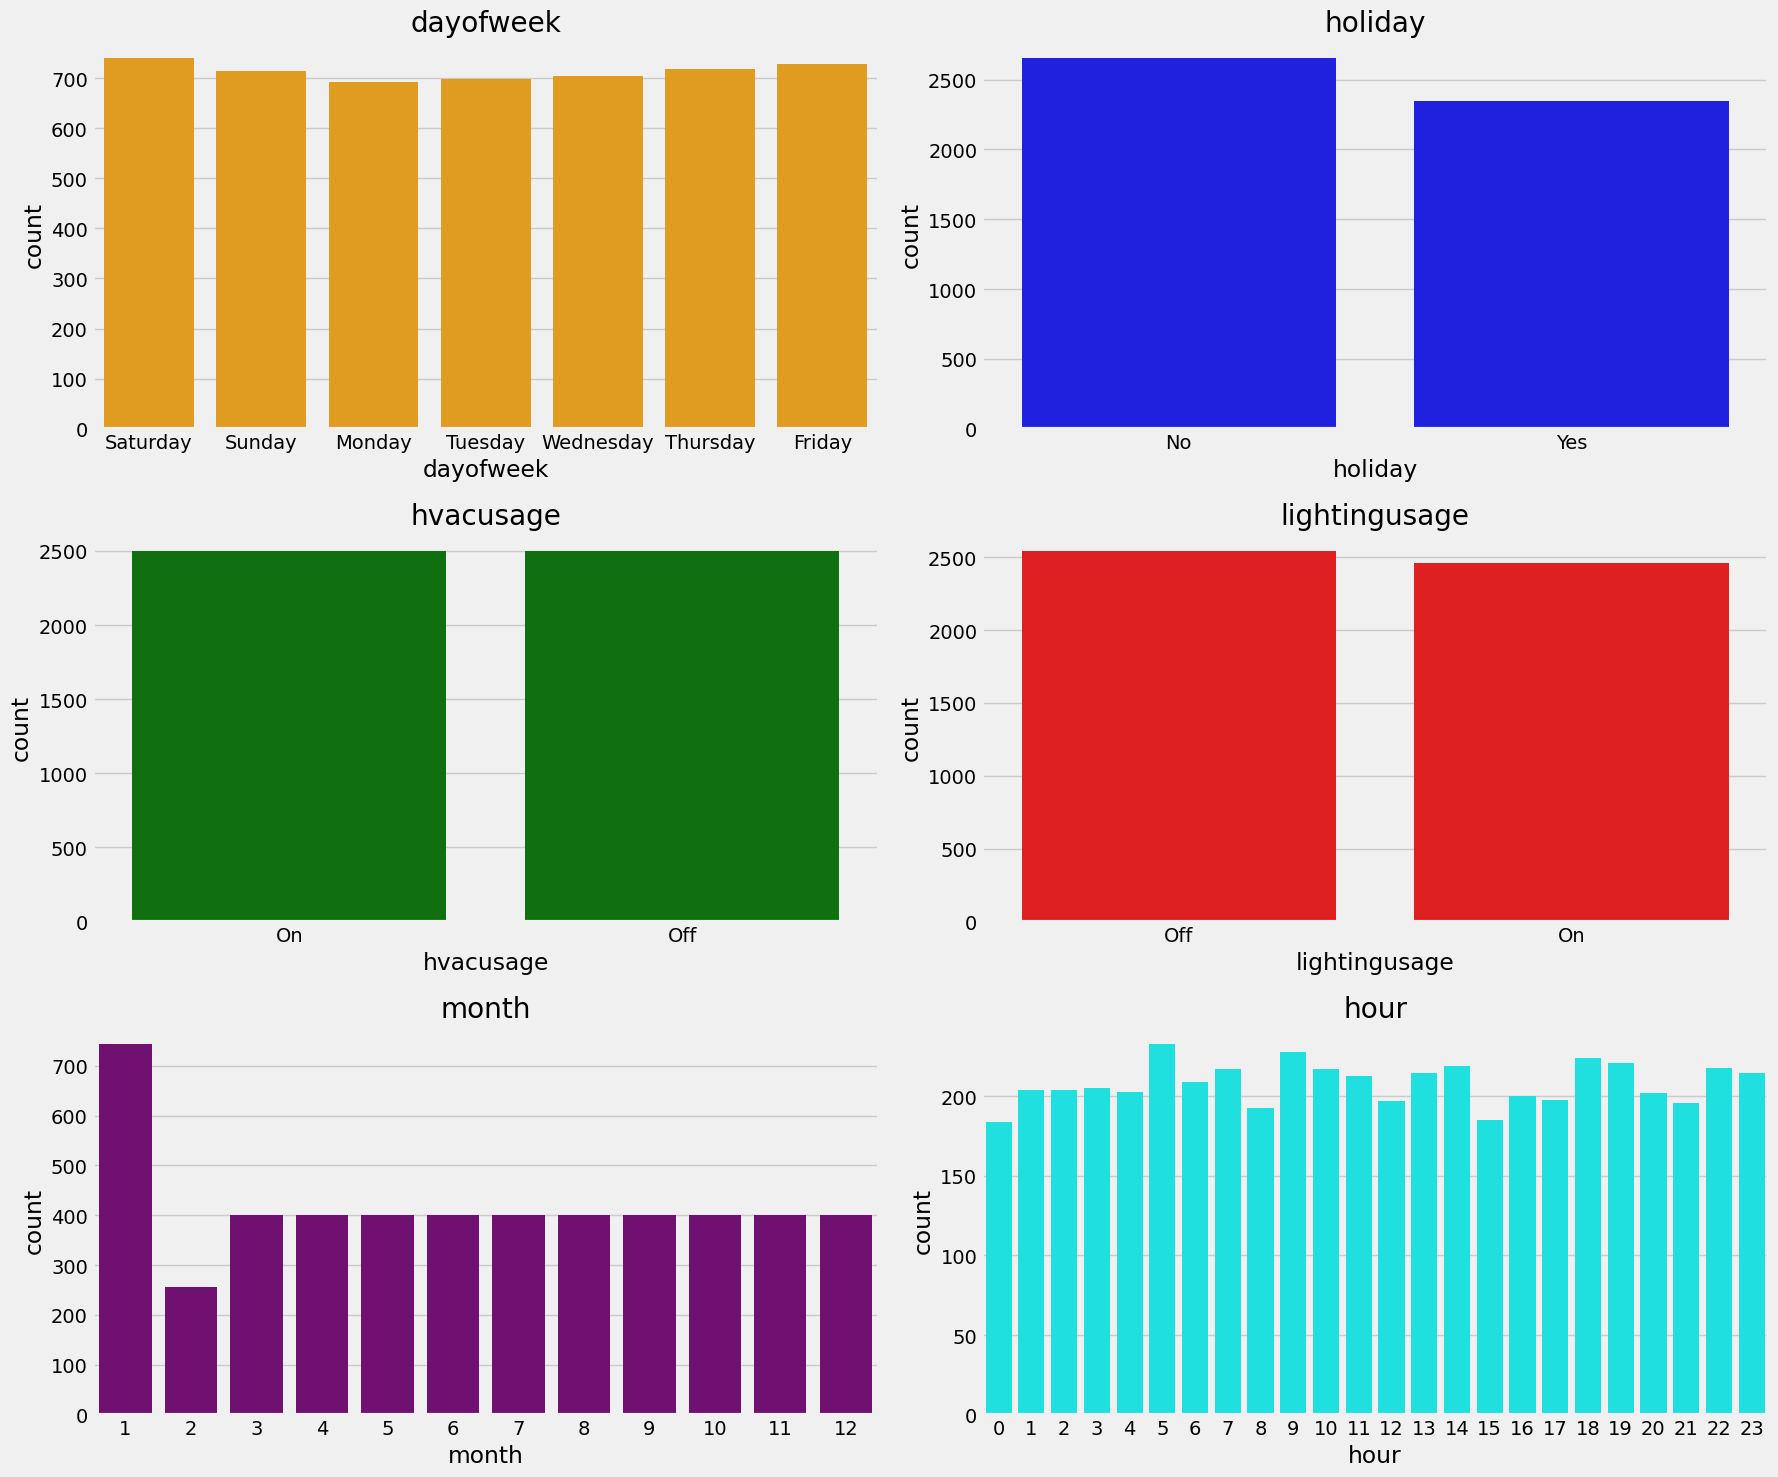

In [37]:
def cat_summary_multiple(dataframe, cat_cols, n_cols=3):
    colors = ['orange', 'blue', 'green', 'red', 'purple', 'cyan', 'brown']
    n_rows = math.ceil(len(cat_cols) / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 5))
    axes = axes.ravel()

    for i, col in enumerate(cat_cols):
        sns.countplot(x=dataframe[col], ax=axes[i], color=colors[i % len(colors)])
        axes[i].set_title(col)

    for j in range(len(cat_cols), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

cat_summary_multiple(df, cat_cols, n_cols=2)

count    5000.000000
mean       24.946823
std         3.041678
min        20.007565
5%         20.007565
10%        20.695541
25%        22.453790
40%        23.947080
50%        24.831846
60%        25.840598
75%        27.427281
90%        29.429914
95%        29.998671
max        29.998671
Name: temperature, dtype: float64


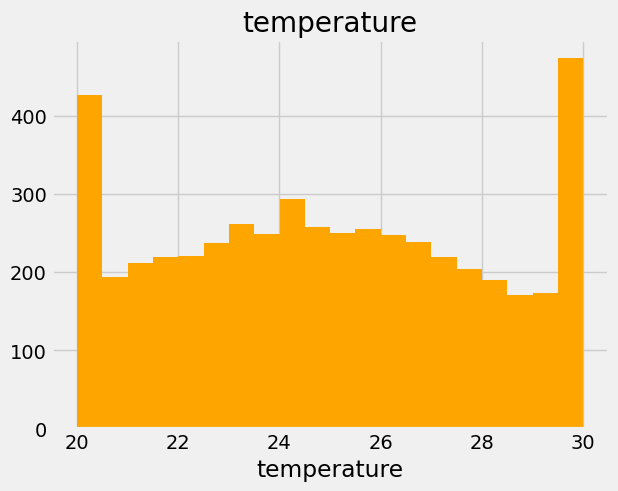


count    5000.000000
mean       45.478146
std         8.972690
min        30.015975
5%         30.187411
10%        32.591025
25%        38.111104
40%        42.833473
50%        45.793124
60%        48.564018
75%        52.696651
90%        58.131609
95%        59.969085
max        59.969085
Name: humidity, dtype: float64


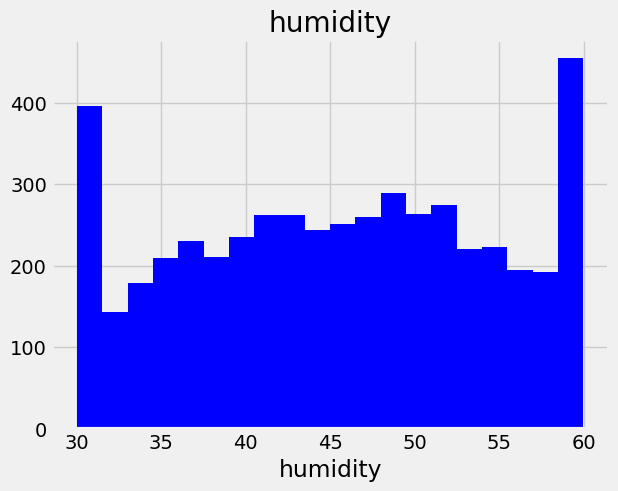


count    5000.000000
mean     1507.403201
std       293.147209
min      1000.512661
5%       1037.646095
10%      1102.194440
25%      1253.906598
40%      1408.010494
50%      1513.581105
60%      1618.945832
75%      1754.846457
90%      1903.463554
95%      1968.451890
max      1999.982252
Name: squarefootage, dtype: float64


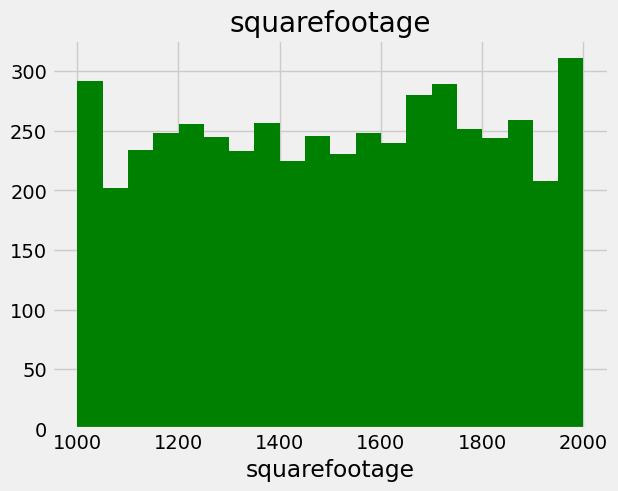


count    5000.000000
mean        4.576000
std         2.906185
min         0.000000
5%          0.000000
10%         0.000000
25%         2.000000
40%         4.000000
50%         5.000000
60%         6.000000
75%         7.000000
90%         9.000000
95%         9.000000
max         9.000000
Name: occupancy, dtype: float64


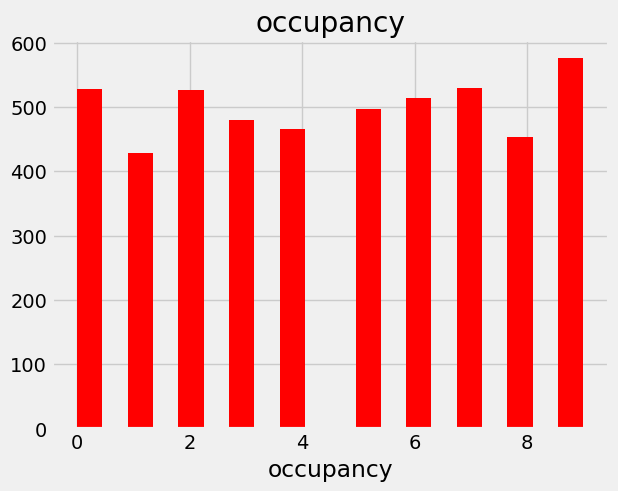


count    5000.000000
mean       15.201195
std         9.157038
min         0.006642
5%          0.006642
10%         2.109967
25%         7.477928
40%        12.174527
50%        15.343830
60%        18.448763
75%        22.889997
90%        27.940651
95%        29.965327
max        29.965327
Name: renewableenergy, dtype: float64


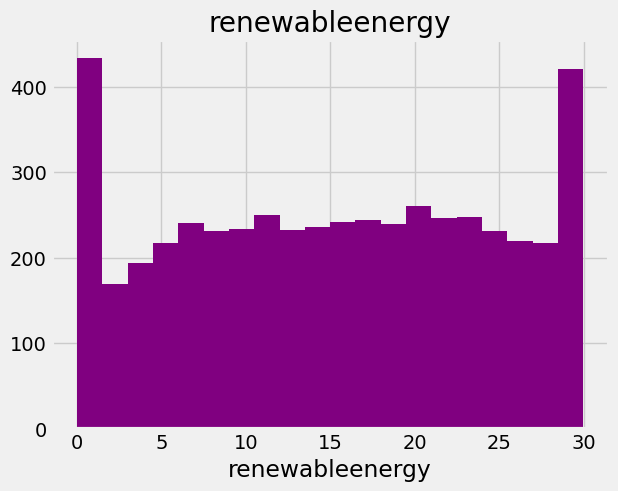


count    5000.000000
mean       76.794919
std         9.231573
min        53.263278
5%         61.490569
10%        64.770303
25%        70.419588
40%        74.327162
50%        76.696267
60%        79.033516
75%        83.246274
90%        89.027658
95%        91.976197
max        99.201120
Name: energyconsumption, dtype: float64


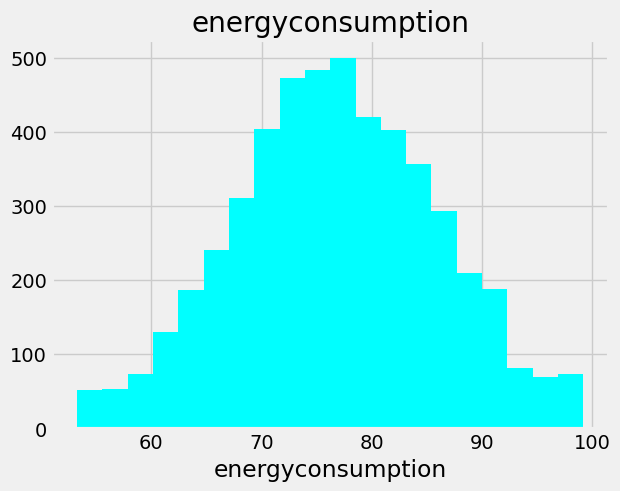

In [38]:
def num_summary(dataframe, col, plot=False,color='orange'):
    quantiles= [0.05, 0.10, 0.25, 0.40, 0.60, 0.75, 0.90, 0.95]
    print(dataframe[col].describe(quantiles).T)
    if plot:
        dataframe[col].hist(bins=20, color=color)
        plt.xlabel(col)
        plt.title(col)
        plt.show()
        print()

colors = ['orange', 'blue', 'green', 'red', 'purple', 'cyan', 'pink', 'gray', 'brown']
for i, col in enumerate(num_cols):
    num_summary(df, col, plot=True, color= colors[i % len(colors)])

# Analysis Of Variables By Target

In [39]:
def target_with_cat(dataframe, cat_col, target):
    print(pd.DataFrame({'Target Mean:':dataframe.groupby(cat_col)[target].mean(),
                        'Count': dataframe[cat_col].value_counts(),
                        'Ratio':dataframe[cat_col].value_counts() / len(dataframe)*100}))
    print()

for col in cat_cols:
    target_with_cat(df, col, 'energyconsumption')

           Target Mean:  Count  Ratio
dayofweek                            
Friday        77.103561    729  14.58
Monday        76.171877    692  13.84
Saturday      77.325581    741  14.82
Sunday        76.578337    715  14.30
Thursday      76.454205    719  14.38
Tuesday       77.210683    699  13.98
Wednesday     76.684472    705  14.10

         Target Mean:  Count  Ratio
holiday                            
No          76.549700   2656  53.12
Yes         77.072778   2344  46.88

           Target Mean:  Count  Ratio
hvacusage                            
Off           76.212791   2500   50.0
On            77.377047   2500   50.0

               Target Mean:  Count  Ratio
lightingusage                            
Off               76.748645   2543  50.86
On                76.842812   2457  49.14

       Target Mean:  Count  Ratio
month                            
1         76.945109    744  14.88
2         77.377782    256   5.12
3         76.990937    400   8.00
4         77.585987 

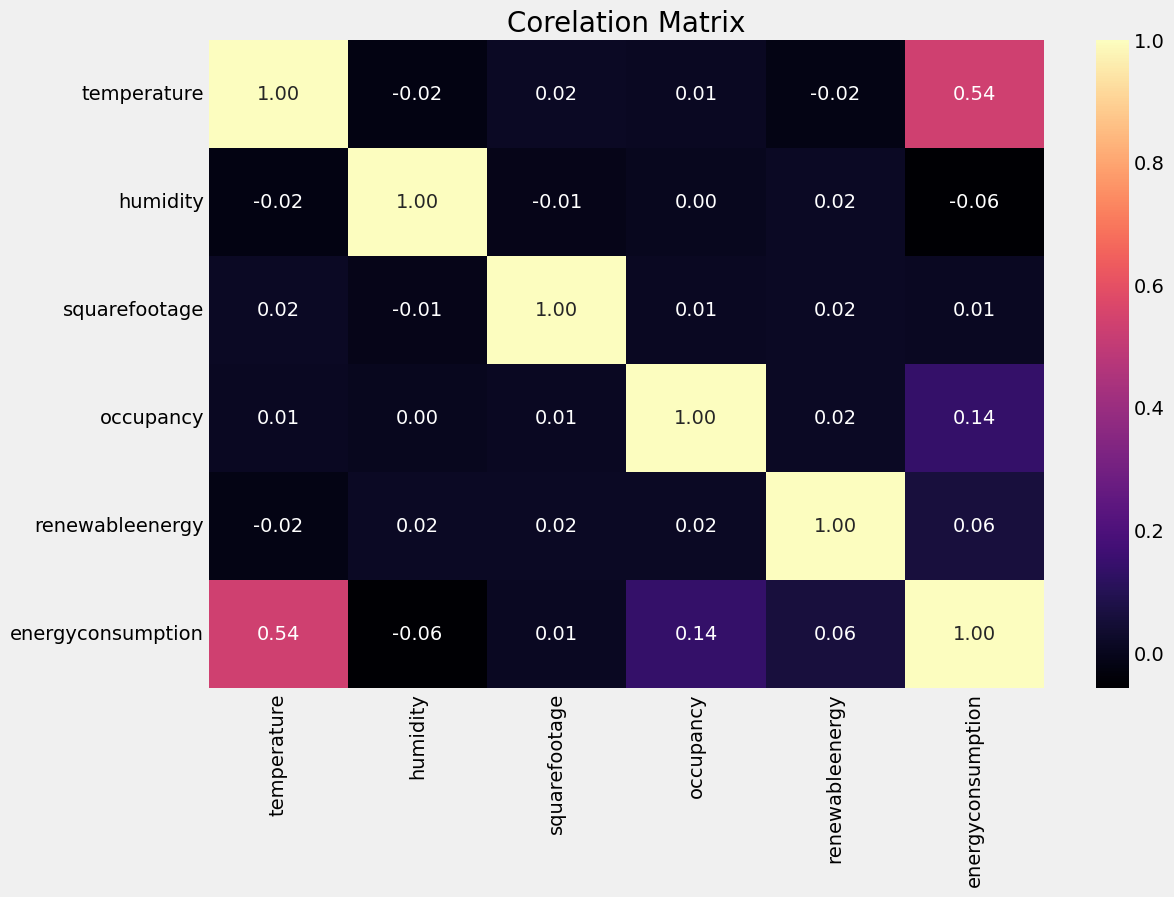

In [40]:
# Numerical Variables and Target(energyconsumption)
f, ax = plt.subplots(figsize=[12,8])
sns.heatmap(df[num_cols].corr(), annot=True, fmt='.2f', ax=ax, cmap='magma')
ax.set_title('Corelation Matrix', fontsize=20)
plt.show()

In [41]:
df[num_cols].corrwith(df['energyconsumption']).sort_values(ascending=False)

,0
energyconsumption,1.000000
temperature,0.535338
occupancy,0.139919
renewableenergy,0.060490
squarefootage,0.009470
humidity,-0.057593


## Outliers Problem

In [42]:
def outlier_thresholds(dataframe, col_name,  q1=0.05, q3=0.95):
    Q1 = dataframe[col_name].quantile(q1)
    Q3 = dataframe[col_name].quantile(q3)
    IQR = Q3 - Q1
    low = Q1 - 1.5*IQR
    up = Q3 + 1.5*IQR
    return low, up

def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)
    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up) )].shape[0] > 10:
      print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up) )].head(10))
    else:
      print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up) )])
    if index:
      outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up) )].index
      return outlier_index

number =1
for col in num_cols:
    print(number, '.', col.upper(), end='\n\n')
    grab_outliers(df, col)
    number += 1

1 . TEMPERATURE

Empty DataFrame
Columns: [month, hour, dayofweek, holiday, temperature, humidity, squarefootage, occupancy, hvacusage, lightingusage, renewableenergy, energyconsumption]
Index: []
2 . HUMIDITY

Empty DataFrame
Columns: [month, hour, dayofweek, holiday, temperature, humidity, squarefootage, occupancy, hvacusage, lightingusage, renewableenergy, energyconsumption]
Index: []
3 . SQUAREFOOTAGE

Empty DataFrame
Columns: [month, hour, dayofweek, holiday, temperature, humidity, squarefootage, occupancy, hvacusage, lightingusage, renewableenergy, energyconsumption]
Index: []
4 . OCCUPANCY

Empty DataFrame
Columns: [month, hour, dayofweek, holiday, temperature, humidity, squarefootage, occupancy, hvacusage, lightingusage, renewableenergy, energyconsumption]
Index: []
5 . RENEWABLEENERGY

Empty DataFrame
Columns: [month, hour, dayofweek, holiday, temperature, humidity, squarefootage, occupancy, hvacusage, lightingusage, renewableenergy, energyconsumption]
Index: []
6 . ENERGYCONS

## Feature Engineering

In [43]:
def seasons(month):
    if month in [12,1,2]:
        return "winter"
    elif month in[3,4,5]:
        return "spring"
    elif month in [6,7,8]:
        return "summer"
    else:
        return "autumn"

In [44]:
df["season"] = df["month"].apply(seasons)

In [45]:
num_cols

['temperature',
 'humidity',
 'squarefootage',
 'occupancy',
 'renewableenergy',
 'energyconsumption']

In [46]:
df['temperature_humidity'] = df['temperature'] * df['humidity']

## Encoding

In [47]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 5000
Variables: 14
cat_cols: 5
num_cols: 9
cat_but_car: 0
num_but_cat: 0


In [48]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df = one_hot_encoder(df, cat_cols, drop_first=True)

## Scaling

In [49]:
X_scaled = MinMaxScaler().fit_transform(df[num_cols])
df[num_cols] = pd.DataFrame(X_scaled, columns=df[num_cols].columns)
df.head()

,month,hour,temperature,humidity,squarefootage,occupancy,renewableenergy,energyconsumption,temperature_humidity,dayofweek_Monday,dayofweek_Saturday,dayofweek_Sunday,dayofweek_Thursday,dayofweek_Tuesday,dayofweek_Wednesday,holiday_Yes,hvacusage_On,lightingusage_On,season_spring,season_summer,season_winter
0,0.0,0.000000,0.513644,0.447887,0.565481,0.555556,0.092396,0.481109,0.409946,False,True,False,False,False,False,False,True,False,False,False,True
1,0.0,0.043478,0.773096,0.808261,0.410770,0.111111,0.728495,0.656073,0.753666,False,True,False,False,False,False,False,True,True,False,False,True
2,0.0,0.086957,0.870445,0.964564,0.755603,0.222222,0.225578,0.544379,0.909807,False,True,False,False,False,False,False,False,False,False,False,True
3,0.0,0.130435,0.007297,0.679584,0.452043,0.111111,0.287623,0.070891,0.342894,False,True,False,False,False,False,False,False,True,False,False,True
4,0.0,0.173913,0.309254,0.713964,0.093667,1.000000,0.102318,0.382004,0.489543,False,True,False,False,False,False,False,True,False,False,False,True


## MODEL

In [50]:
y = df['energyconsumption']
X = df.drop(['energyconsumption'], axis=1)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=111)

In [52]:
# Shape Control
print("Train set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

Train set shape: (4000, 20)
Test set shape: (1000, 20)
y_train shape: (4000,)
y_test shape: (1000,)


### Linear Regression

In [53]:
#Model Training
model1 = LinearRegression()
model1.fit(X_train, y_train)

LinearRegression()

In [54]:
y_pred_train = model1.predict(X_train)
y_pred_test = model1.predict(X_test)

In [56]:
train_rmse = mean_squared_error(y_train, y_pred_train)
test_rmse = mean_squared_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

In [58]:
print(f"Linear Regression Results:")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Train R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")

Linear Regression Results:
Train RMSE: 0.0272
Test RMSE: 0.0293
Train R²: 0.3262
Test R²: 0.2718


### Decision Tree Regression

In [59]:
model2 = DecisionTreeRegressor(random_state=111)
model2.fit(X_train, y_train)

DecisionTreeRegressor(random_state=111)

In [60]:
y_pred_train = model2.predict(X_train)
y_pred_test = model2.predict(X_test)

In [61]:
train_rmse = mean_squared_error(y_train, y_pred_train)
test_rmse = mean_squared_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

In [63]:
print(f"Decision Tree Regression Results:")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Train R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")

Decision Tree Regression Results:
Train RMSE: 0.0000
Test RMSE: 0.0608
Train R²: 1.0000
Test R²: -0.5124


### Random Forest Regression

In [64]:
model3 = RandomForestRegressor(random_state=111, n_estimators=100)
model3.fit(X_train, y_train)

RandomForestRegressor(random_state=111)

In [65]:
y_pred_train = model3.predict(X_train)
y_pred_test = model3.predict(X_test)

In [66]:
train_rmse = mean_squared_error(y_train, y_pred_train)
test_rmse = mean_squared_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

In [67]:
print(f"Random Forest Regression Results:")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Train R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")

Random Forest Regression Results:
Train RMSE: 0.0039
Test RMSE: 0.0304
Train R²: 0.9023
Test R²: 0.2446


### Model comparison

In [68]:
# Model comparison
models = ['Linear Regression', 'Decision Tree', 'Random Forest']
test_rmse_scores = [0.0293, 0.0608, 0.0304]
test_r2_scores = [0.2718, -0.5124, 0.2446]

print("MODEL COMPARISON:")
print("=" * 50)
for i, model in enumerate(models):
    print(f"{model:20} | Test RMSE: {test_rmse_scores[i]:.4f} | Test R²: {test_r2_scores[i]:.4f}")

MODEL COMPARISON:
Linear Regression    | Test RMSE: 0.0293 | Test R²: 0.2718
Decision Tree        | Test RMSE: 0.0608 | Test R²: -0.5124
Random Forest        | Test RMSE: 0.0304 | Test R²: 0.2446


* Linear Regression is the best model.

# Hiperparametre Optimization

In [70]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score

print("REGULARIZED LINEAR MODELS:")
print("=" * 40)

# Ridge Regression
ridge = Ridge(alpha=1.0, random_state=111)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
ridge_rmse = mean_squared_error(y_test, y_pred_ridge)
ridge_r2 = r2_score(y_test, y_pred_ridge)
print(f"Ridge Regression:")
print(f"Test RMSE: {ridge_rmse:.4f}")
print(f"Test R²: {ridge_r2:.4f}")

REGULARIZED LINEAR MODELS:
Ridge Regression:
Test RMSE: 0.0293
Test R²: 0.2720


## HO With GridSearchCV

In [72]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

ridge_grid = GridSearchCV(Ridge(random_state=111),
                         param_grid,
                         cv=5,
                         scoring='neg_mean_squared_error',
                         n_jobs=-1)

ridge_grid.fit(X_train, y_train)

# Best parameters and results
print("Ridge Regression - GridSearch Results:")
print(f"Best Alpha: {ridge_grid.best_params_['alpha']}")
print(f"Best CV Score: {-ridge_grid.best_score_:.4f}")

# Test with best model
best_ridge = ridge_grid.best_estimator_
y_pred_best_ridge = best_ridge.predict(X_test)
best_ridge_rmse = mean_squared_error(y_test, y_pred_best_ridge)
best_ridge_r2 = r2_score(y_test, y_pred_best_ridge)

print(f"Best Ridge Test RMSE: {best_ridge_rmse:.4f}")
print(f"Best Ridge Test R²: {best_ridge_r2:.4f}")

Ridge Regression - GridSearch Results:
Best Alpha: 1
Best CV Score: 0.0276
Best Ridge Test RMSE: 0.0293
Best Ridge Test R²: 0.2720


In [74]:
# Lasso
lasso = Lasso(alpha=0.1, random_state=111)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)
lasso_rmse = mean_squared_error(y_test, y_pred_lasso)
lasso_r2 = r2_score(y_test, y_pred_lasso)

print(f"\nLasso Regression (alpha=0.1):")
print(f"Test RMSE: {lasso_rmse:.4f}")
print(f"Test R²: {lasso_r2:.4f}")

non_zero_coef = np.sum(lasso.coef_ != 0)
print(f"Non-zero coefficients: {non_zero_coef}/{len(lasso.coef_)}")


Lasso Regression (alpha=0.1):
Test RMSE: 0.0403
Test R²: -0.0032
Non-zero coefficients: 0/20


In [76]:
lasso_param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]
}

lasso_grid = GridSearchCV(Lasso(random_state=111),
                         lasso_param_grid,
                         cv=5,
                         scoring='neg_mean_squared_error',
                         n_jobs=-1)

lasso_grid.fit(X_train, y_train)

print("Lasso Regression - GridSearch Results:")
print(f"Best Alpha: {lasso_grid.best_params_['alpha']}")
print(f"Best CV Score: {-lasso_grid.best_score_:.4f}")

# Test with best Lasso model
best_lasso = lasso_grid.best_estimator_
y_pred_best_lasso = best_lasso.predict(X_test)
best_lasso_rmse = mean_squared_error(y_test, y_pred_best_lasso)
best_lasso_r2 = r2_score(y_test, y_pred_best_lasso)

print(f"Best Lasso Test RMSE: {best_lasso_rmse:.4f}")
print(f"Best Lasso Test R²: {best_lasso_r2:.4f}")

non_zero_coef_best = np.sum(best_lasso.coef_ != 0)
print(f"Non-zero coefficients: {non_zero_coef_best}/{len(best_lasso.coef_)}")

Lasso Regression - GridSearch Results:
Best Alpha: 0.001
Best CV Score: 0.0275
Best Lasso Test RMSE: 0.0291
Best Lasso Test R²: 0.2754
Non-zero coefficients: 10/20


In [77]:
# Data Characteristics
print("\nDATA CHARACTERISTICS:")
print("=" * 30)
print(f"Feature names: {X_train.columns.tolist()}")
print(f"Training set shape: {X_train.shape}")
print(f"Target variable stats:")
print(f"  y_train mean: {y_train.mean():.4f}")
print(f"  y_train std: {y_train.std():.4f}")
print(f"  y_test mean: {y_test.mean():.4f}")
print(f"  y_test std: {y_test.std():.4f}")


DATA CHARACTERISTICS:
Feature names: ['month', 'hour', 'temperature', 'humidity', 'squarefootage', 'occupancy', 'renewableenergy', 'temperature_humidity', 'dayofweek_Monday', 'dayofweek_Saturday', 'dayofweek_Sunday', 'dayofweek_Thursday', 'dayofweek_Tuesday', 'dayofweek_Wednesday', 'holiday_Yes', 'hvacusage_On', 'lightingusage_On', 'season_spring', 'season_summer', 'season_winter']
Training set shape: (4000, 20)
Target variable stats:
  y_train mean: 0.5145
  y_train std: 0.2010
  y_test mean: 0.5032
  y_test std: 0.2005


# Final Model  Comparison

In [78]:
# Final model comparison
final_models = {
    'Linear Regression': {'RMSE': 0.0293, 'R2': 0.2718},
    'Decision Tree': {'RMSE': 0.0608, 'R2': -0.5124},
    'Random Forest': {'RMSE': 0.0304, 'R2': 0.2446},
    'Ridge (default)': {'RMSE': 0.0293, 'R2': 0.2720},
    'Lasso (optimized)': {'RMSE': 0.0291, 'R2': 0.2754}
}

print("FINAL MODEL COMPARISON:")
print("=" * 55)
print(f"{'Model':<20} | {'Test RMSE':<10} | {'Test R²':<8} | {'Status':<10}")
print("-" * 55)
for model, scores in final_models.items():
    best_rmse = scores['RMSE'] == min([m['RMSE'] for m in final_models.values()])
    best_r2 = scores['R2'] == max([m['R2'] for m in final_models.values()])
    status = "✓ BEST" if best_rmse and best_r2 else ""
    print(f"{model:<20} | {scores['RMSE']:<10.4f} | {scores['R2']:<8.4f} | {status:<10}")

FINAL MODEL COMPARISON:
Model                | Test RMSE  | Test R²  | Status    
-------------------------------------------------------
Linear Regression    | 0.0293     | 0.2718   |           
Decision Tree        | 0.0608     | -0.5124  |           
Random Forest        | 0.0304     | 0.2446   |           
Ridge (default)      | 0.0293     | 0.2720   |           
Lasso (optimized)    | 0.0291     | 0.2754   | ✓ BEST    


# Feature Importance


LASSO FEATURE IMPORTANCE:
                 feature  coefficient  abs_coefficient
2            temperature     0.346914         0.346914
5              occupancy     0.076387         0.076387
6        renewableenergy     0.033657         0.033657
15          hvacusage_On     0.017986         0.017986
3               humidity    -0.014551         0.014551
9     dayofweek_Saturday     0.005893         0.005893
14           holiday_Yes     0.005809         0.005809
8       dayofweek_Monday    -0.005417         0.005417
19         season_winter     0.004209         0.004209
16      lightingusage_On     0.002711         0.002711
0                  month    -0.000000         0.000000
1                   hour    -0.000000         0.000000
11    dayofweek_Thursday    -0.000000         0.000000
10      dayofweek_Sunday    -0.000000         0.000000
4          squarefootage     0.000000         0.000000
7   temperature_humidity    -0.000000         0.000000
12     dayofweek_Tuesday     0.000000 

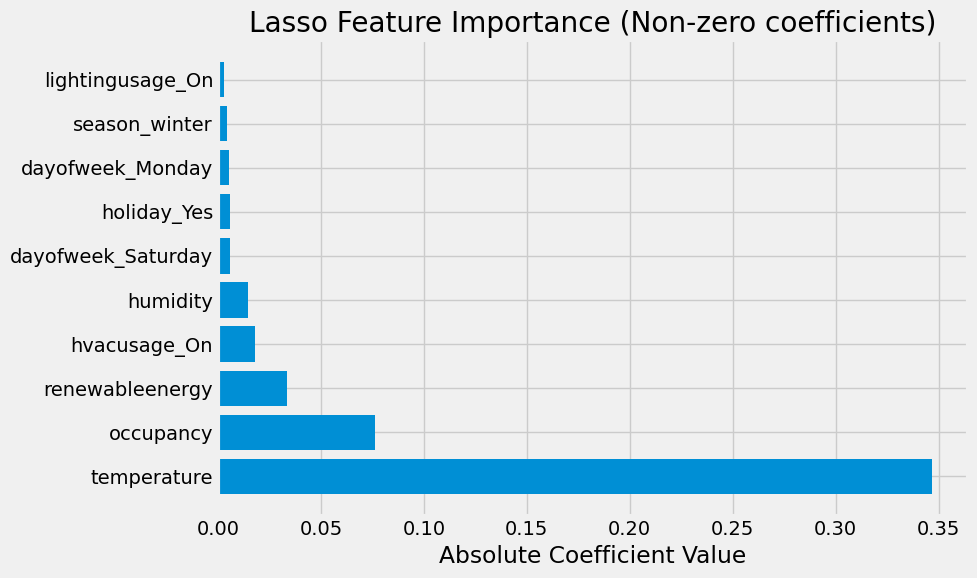

In [79]:
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': best_lasso.coef_,
    'abs_coefficient': np.abs(best_lasso.coef_)
}).sort_values('abs_coefficient', ascending=False)

print("\nLASSO FEATURE IMPORTANCE:")
print("=" * 40)
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
important_features = feature_importance[feature_importance['abs_coefficient'] > 0]
plt.barh(important_features['feature'], important_features['abs_coefficient'])
plt.xlabel('Absolute Coefficient Value')
plt.title('Lasso Feature Importance (Non-zero coefficients)')
plt.tight_layout()
plt.show()